<a href="https://colab.research.google.com/github/Aidin-Poorsolhjouy/DT2/blob/main/01_DT2_PDM_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook focuses on developing and evaluating a Random Forest model for predictive maintenance using the AI4I 2020 Predictive Maintenance Dataset.

The notebook implements a modular approach, encapsulating data preprocessing, model training, and evaluation within reusable functions. This is for easy experimentation with different *preprocessing techniques*, *feature sets*, and *model parameters*.

The notebook includes data preprocessing steps such as
- train/test splitting
- type encoding
- feature scaling
- oversampling to address class imbalance.

It also provides visualizations of the *learning curve* and *feature importance* to gain insights into the model's behavior and identify key factors influencing machine failures.

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, matthews_corrcoef
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from sklearn.inspection import permutation_importance
import time
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset and Creating new features

In [ ]:
df = pd.read_csv('ai4i2020.csv')
df.rename(columns={'Air temperature [K]': 'Air temperature K', 'Process temperature [K]': 'Process temperature K'
, 'Rotational speed [rpm]': 'Rotational speed rpm', 'Torque [Nm]' : 'Torque Nm', 'Tool wear [min]': 'Tool wear min'}, inplace=True)
# with int type, the scaler transformer gives warning
df['Rotational speed rpm'] = df['Rotational speed rpm'].astype(float)
df['Tool wear min'] = df['Tool wear min'].astype(float)

df['dt']=df['Process temperature K']-df['Air temperature K']
df['power']=df['Torque Nm']*df['Rotational speed rpm']
df['strain']=df['Torque Nm']*df['Tool wear min']


# Define scalings
scalings = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "log",
     "Torque Nm": "standard",
     "Tool wear min": "minmax", #minmax
     "dt": "standard",
     "power": "standard",
     "strain": "log" #log
 }
scalingsstd = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "standard",
     "Torque Nm": "standard",
     "Tool wear min": "standard", #minmax
     "dt": "standard",
     "power": "standard",
     "strain": "standard" #log
 }

#Functions

##Preprocessing Function

In [ ]:
def preprocess_data(df, features, target, test_size=0.2, val_size = 0.2, manual_tune = True, random_state=42, scalings=None, oversampling=None):
    """
    Preprocesses the data, including train/test split, type encoding, scaling, and oversampling.

    Args:
        df (pd.DataFrame): The input DataFrame.
        features (list): List of feature names.
        target (str): The name of the target variable.
        test_size (float): The proportion of the data to use for testing.
        random_state (int): Random state for reproducibility.
        scalings (dict): Dictionary of scaling methods for each feature.
        oversampling (str): Oversampling method ('smote', 'svmsmote', 'randomoversampler', or None).

    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """

    # Create copies to avoid modifying the original DataFrame
    df = df.copy()

    if manual_tune:

      # Split into train (60%), validation (20%), and test (20%) before any analysis.
      # use stratify over the machine failure, to have the same distribution in the sets.
      df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])
      df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42, stratify=df_train[target])
    else:
      # Train/Test Split
      df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target])

    # Type Encoding
    df_train['Type'] = df_train['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    df_test['Type'] = df_test['Type'].replace({'L': 0, 'M': 1, 'H': 2})
    if manual_tune:
      df_val['Type'] = df_val['Type'].replace({'L': 0, 'M': 1, 'H': 2})

    # Separate features and target
    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]
    X_val = None
    y_val = None

    if manual_tune:
      X_val = df_val[features]
      y_val = df_val[target]

    # Imputation
    # Create separate imputers for 'Rotational speed rpm' and other numerical features
    imputer_rotational_speed = SimpleImputer(strategy='median')
    imputer_other = SimpleImputer(strategy='mean')

    # Impute 'Rotational speed rpm'
    X_train['Rotational speed rpm'] = imputer_rotational_speed.fit_transform(X_train[['Rotational speed rpm']])
    X_test['Rotational speed rpm'] = imputer_rotational_speed.transform(X_test[['Rotational speed rpm']])
    if manual_tune:
      X_val['Rotational speed rpm'] = imputer_rotational_speed.transform(X_val[['Rotational speed rpm']])

    # Impute other numerical features
    numerical_features_to_impute = [f for f in features if f != 'Rotational speed rpm']
    X_train[numerical_features_to_impute] = imputer_other.fit_transform(X_train[numerical_features_to_impute])
    X_test[numerical_features_to_impute] = imputer_other.transform(X_test[numerical_features_to_impute])

    if manual_tune:
      X_val[numerical_features_to_impute] = imputer_other.transform(X_val[numerical_features_to_impute])

    # Oversampling
    if oversampling == "smote":
        oversampler = SMOTE(random_state=random_state)
    elif oversampling == "svmsmote":
        oversampler = SVMSMOTE(random_state=random_state)
    elif oversampling == "randomoversampler":
        oversampler = RandomOverSampler(random_state=random_state)
    else:
        oversampler = None

    if oversampling:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # Scaling
    if scalings:
        scalers = {
            "standard": StandardScaler(),
            "minmax": MinMaxScaler(),
            "log": FunctionTransformer(np.log1p)  # log1p to handle zero values safely
        }
        for feature in features:
            if feature in scalings:
                scaler = scalers[scalings[feature]]
                X_train.loc[:, feature] = scaler.fit_transform(X_train[[feature]])
                X_test.loc[:, feature] = scaler.transform(X_test[[feature]])
                if manual_tune:
                  X_val.loc[:, feature] = scaler.transform(X_val[[feature]])

    return X_train, X_val, X_test, y_train, y_val, y_test

## Random Forest Model

In [ ]:
def train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val = None, y_val=None, randomized_search=False, random_state=42, cv=5, n_iter=15,
                           n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None):
    """
    Trains and evaluates a Random Forest model, with or without Randomized Search.

    Args:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
        randomized_search (bool): Whether to perform Randomized Search.
        random_state (int): Random state for reproducibility.
        cv (int): Number of cross-validation folds.
        n_iter (int): Number of iterations for Randomized Search.
        n_estimators (int): Number of trees in the forest (if randomized_search is False).
        max_depth (int): Maximum depth of the trees (if randomized_search is False).
        min_samples_split (int): Minimum number of samples required to split an internal node (if randomized_search is False).
        min_samples_leaf (int): Minimum number of samples required to be at a leaf node (if randomized_search is False).
        class_weight (str): Class weight for handling imbalanced data (if randomized_search is False).

    Returns:
        tuple: (trained model, dictionary of evaluation metrics, training time, inference time)
    """

    # Define the parameter distribution
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }

    # Initialize Random Forest
    rf_model = RandomForestClassifier(random_state=random_state)

    # Perform Randomized Search
    best_estimators = []
    if randomized_search:
        print("Performing Randomized Search...")
        start_time = time.time()
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
        random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions,
                                              n_iter=n_iter, scoring='f1', cv=skf, n_jobs=-1, verbose=1, random_state=random_state)
        random_search_rf.fit(X_train, y_train)
        training_time = time.time() - start_time

        print("Best parameters found:", random_search_rf.best_params_)
        rf_model = random_search_rf.best_estimator_

        # Get the results as a DataFrame
        results_df = pd.DataFrame(random_search_rf.cv_results_)

        # Sort by the mean test score (validation score)
        results_df = results_df.sort_values(by='mean_test_score', ascending=False)

        # Select the top 5 models
        top_5_models = results_df.head(5)

        # Print the best parameters and scores for the top 5 models
        print("Next 4 Models:")
        for i in range(4):
            print(f"\nModel {i+2}:")
            print(f"  Parameters: {top_5_models['params'].iloc[i+1]}")
            print(f"  Mean Test Score: {top_5_models['mean_test_score'].iloc[i+1]:.2f}")

        # Access the actual trained models (estimators)
        for i in range(5):
            best_estimators.append(random_search_rf.estimator.set_params(**top_5_models['params'].iloc[i]))
            # Make predictions
        start_time = time.time()
        y_pred = rf_model.predict(X_test)
        inference_time = time.time() - start_time

        # Evaluate the model
        metrics = {
            "mcc": matthews_corrcoef(y_test, y_pred),
            "training_time": training_time,
            "inference_time": inference_time
        }
    else:
        print("Training Random Forest without Randomized Search...")
        start_time = time.time()
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf, class_weight=class_weight, random_state=random_state)
        rf_model.fit(X_train, y_train)
        training_time = time.time() - start_time

        if X_val is not None and y_val is not None:
          # Make predictions
          start_time = time.time()
          y_pred_val = rf_model.predict(X_val)
          inference_time = time.time() - start_time

          # Evaluate the model
          metrics = {
              "mcc": matthews_corrcoef(y_val, y_pred_val),
              "training_time": training_time,
              "inference_time": inference_time
          }
        else:
          # Make predictions
          start_time = time.time()
          y_pred = rf_model.predict(X_test)
          inference_time = time.time() - start_time

          # Evaluate the model
          metrics = {
              "mcc": matthews_corrcoef(y_test, y_pred),
              "training_time": training_time,
              "inference_time": inference_time
          }

    return rf_model, metrics, best_estimators

##Learning Curve Function

In [ ]:
def plot_learning_curve(model, X_train, y_train, scoring="f1", cv=5):
    """
    Plots the learning curve for a given model.

    Args:
        model: Trained model.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        scoring (str): Scoring metric for learning curve.
        cv (int): Number of cross-validation folds.
    """
    skf = StratifiedKFold(n_splits=cv)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean and std for train and validation scores
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(5, 3))
    plt.plot(train_sizes, train_mean, label="Training score", color="blue")
    plt.plot(train_sizes, val_mean, label="Validation score", color="green")
    plt.title("Learning Curve for Random Forest")
    plt.xlabel("Training Size")
    plt.ylabel("F1")
    plt.legend()
    plt.show()

## Feature Importance Function

In [ ]:
def plot_feature_importance(model, X_train):
    """
    Plots the feature importance for a given model.

    Args:
        model: Trained model.
        X_train (pd.DataFrame): Training features.
    """
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=feature_importances)
    plt.title('Feature Importances (Random Forest)')
    plt.show()

##Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm):
  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(2, 2))  # Adjust figure size as needed
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # Customize the heatmap
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.show()

#Apply ML

## Tier 1 - Variations in features, w/wo scaling, w/wo oversampling

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.90      0.51      0.65        68

    accuracy                           0.98      2000
   macro avg       0.94      0.76      0.82      2000
weighted avg       0.98      0.98      0.98      2000

mcc: 0.67
training_time: 1.56
inference_time: 0.03


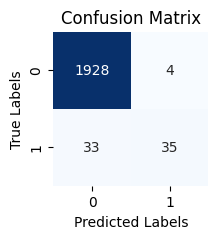

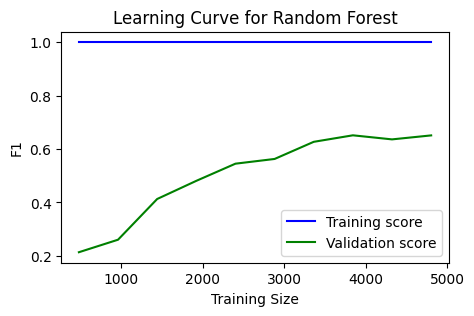

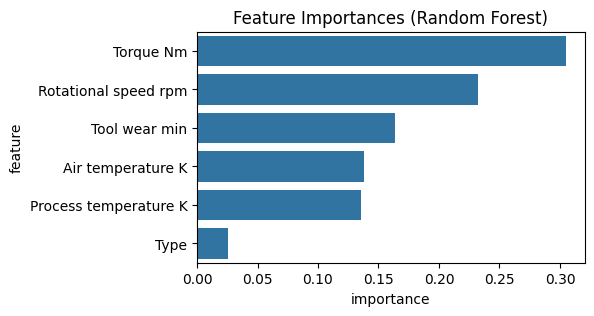

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.88      0.53      0.66        68

    accuracy                           0.98      2000
   macro avg       0.93      0.76      0.83      2000
weighted avg       0.98      0.98      0.98      2000

mcc: 0.67
training_time: 1.77
inference_time: 0.06


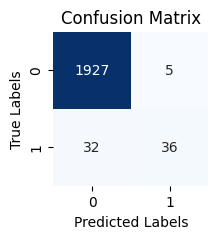

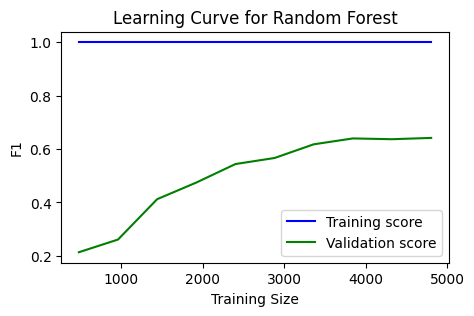

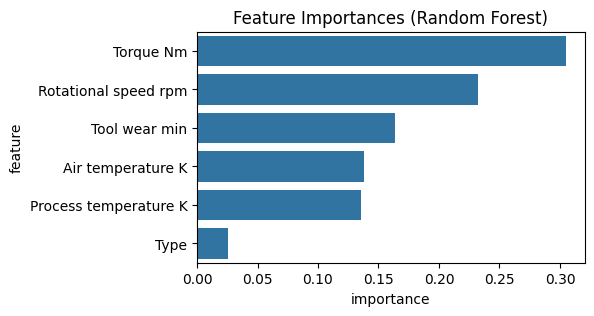

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.88      0.53      0.66        68

    accuracy                           0.98      2000
   macro avg       0.93      0.76      0.83      2000
weighted avg       0.98      0.98      0.98      2000

mcc: 0.67
training_time: 1.35
inference_time: 0.04


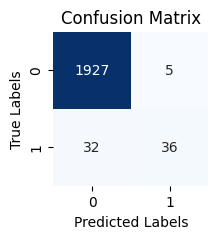

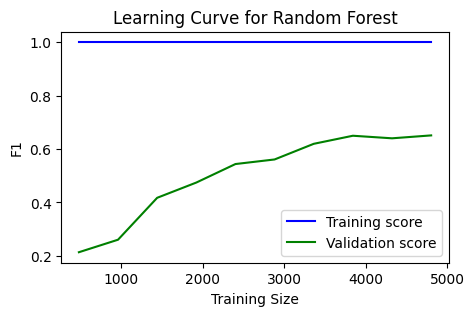

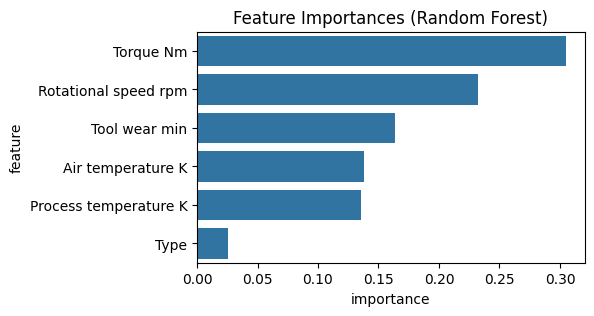

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalingsstd, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Train set shape: (6000, 6)
Test set shape: (2000, 6)
Val set shape: (2000, 6)
Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.50      0.75      0.60        68

    accuracy                           0.97      2000
   macro avg       0.74      0.86      0.79      2000
weighted avg       0.97      0.97      0.97      2000

mcc: 0.59
training_time: 3.88
inference_time: 0.04


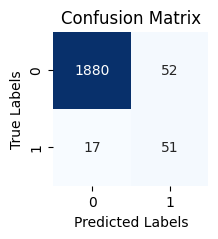

(11594, 6)


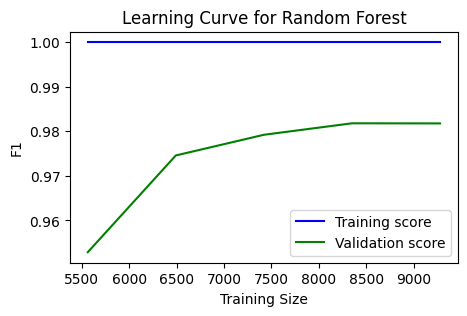

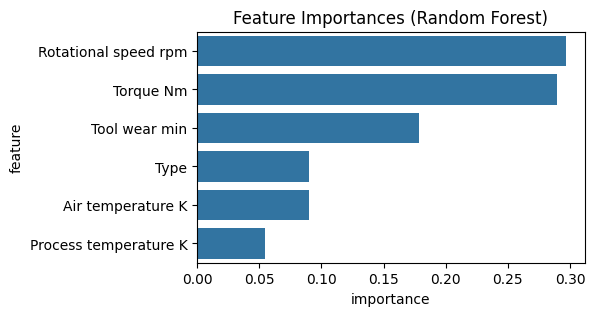

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling='smote', manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1932
           1       0.51      0.66      0.57        68

    accuracy                           0.97      2000
   macro avg       0.75      0.82      0.78      2000
weighted avg       0.97      0.97      0.97      2000

mcc: 0.56
training_time: 1.69
inference_time: 0.02


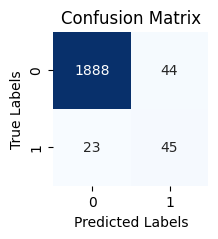

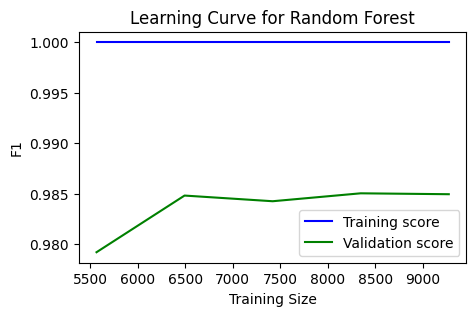

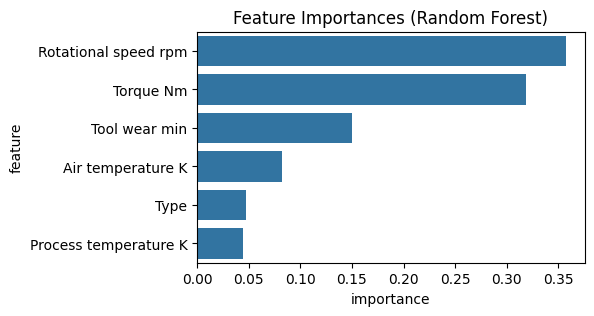

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling='svmsmote', manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1932
           1       0.76      0.50      0.60        68

    accuracy                           0.98      2000
   macro avg       0.87      0.75      0.80      2000
weighted avg       0.97      0.98      0.98      2000

mcc: 0.60
training_time: 2.35
inference_time: 0.11


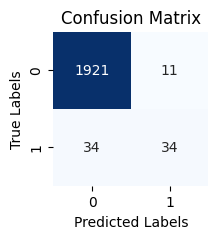

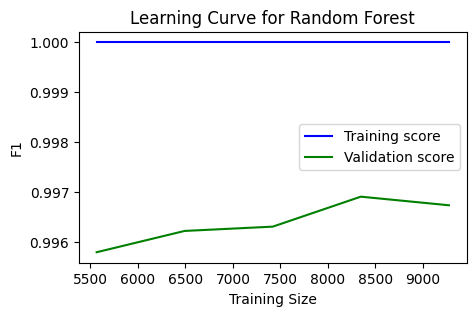

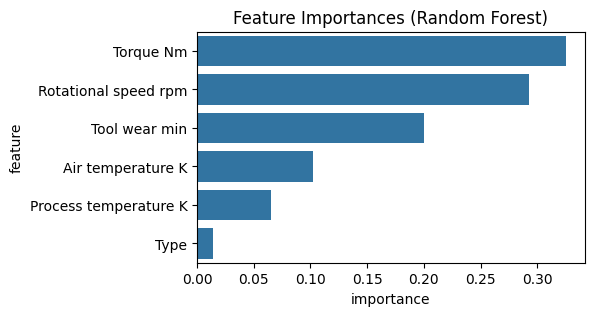

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling='randomoversampler', manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.86      0.35      0.50        68

    accuracy                           0.98      2000
   macro avg       0.92      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000

mcc: 0.54
training_time: 0.97
inference_time: 0.03


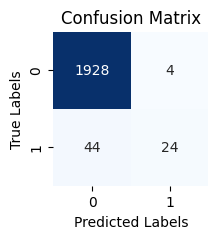

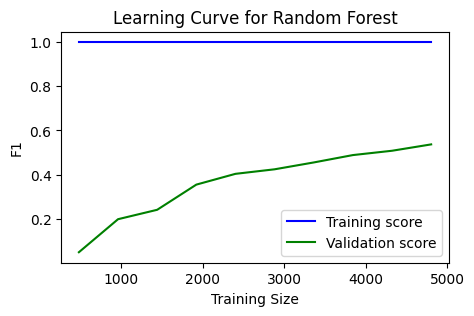

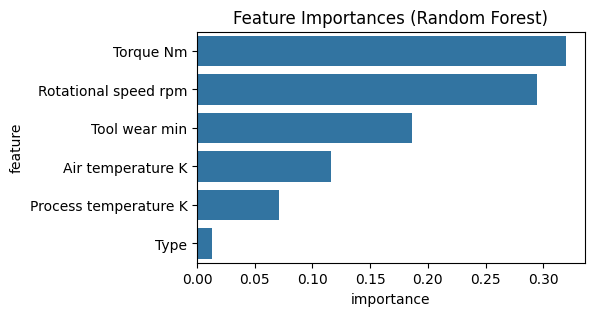

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, class_weight='balanced')

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.94      0.74      0.83        68

    accuracy                           0.99      2000
   macro avg       0.97      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.83
training_time: 1.71
inference_time: 0.12


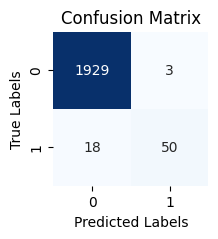

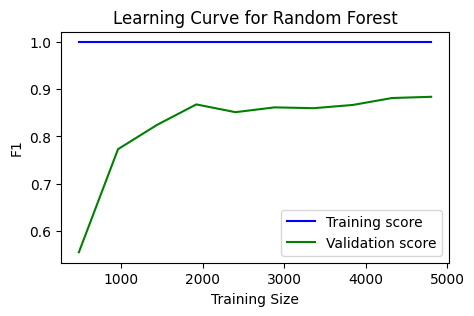

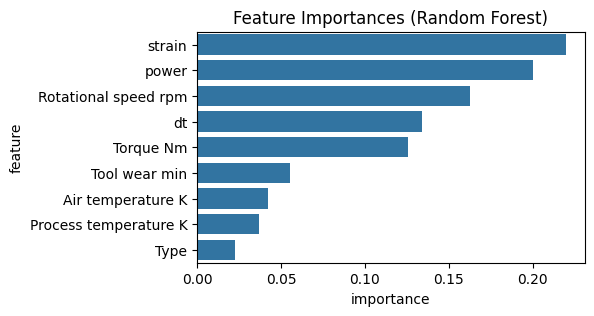

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.96      0.74      0.83        68

    accuracy                           0.99      2000
   macro avg       0.98      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.84
training_time: 1.62
inference_time: 0.03


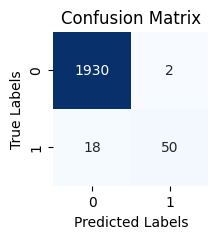

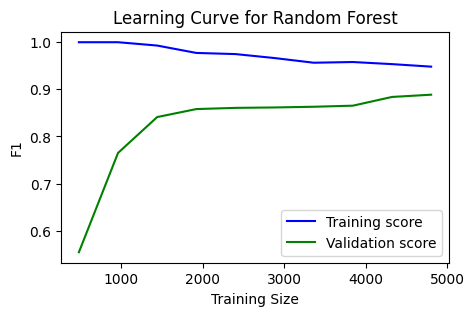

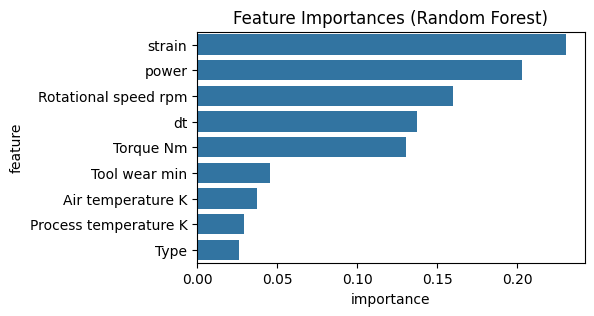

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, max_depth=10)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.93      0.74      0.82        68

    accuracy                           0.99      2000
   macro avg       0.96      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.82
training_time: 1.68
inference_time: 0.03


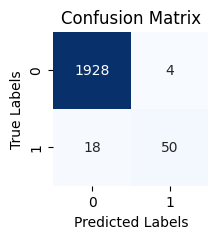

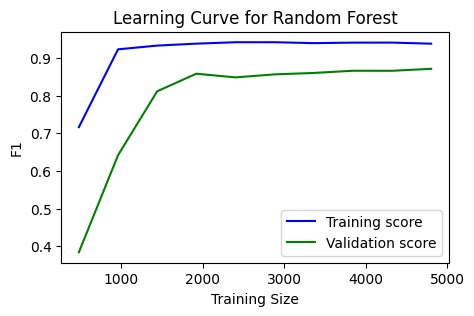

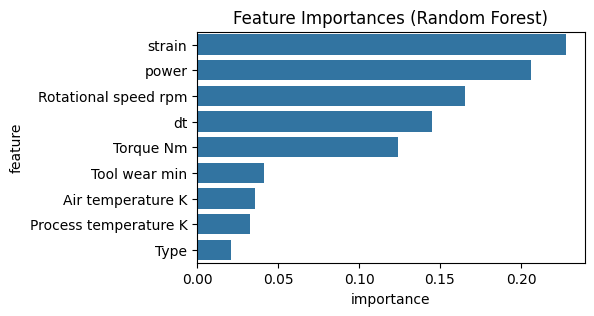

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, min_samples_leaf=2)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.94      0.74      0.83        68

    accuracy                           0.99      2000
   macro avg       0.97      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.83
training_time: 2.81
inference_time: 0.06


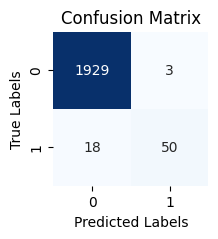

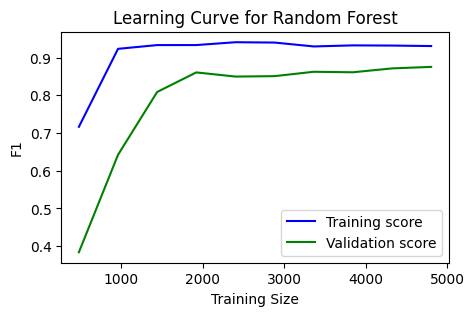

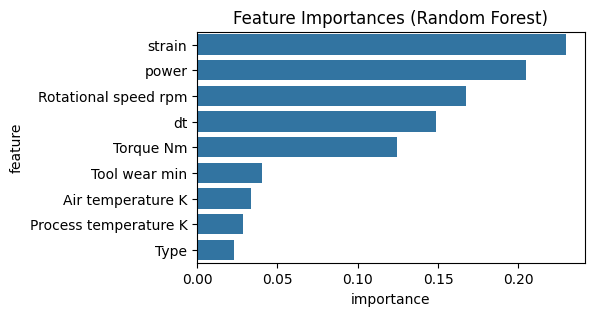

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, max_depth=10, min_samples_leaf = 2)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.89      0.74      0.81        68

    accuracy                           0.99      2000
   macro avg       0.94      0.87      0.90      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.80
training_time: 1.44
inference_time: 0.03


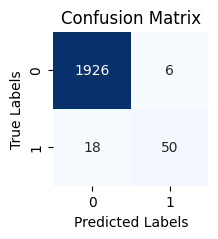

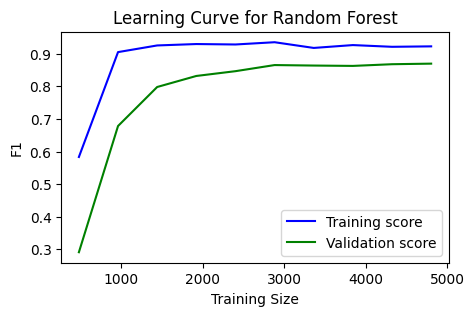

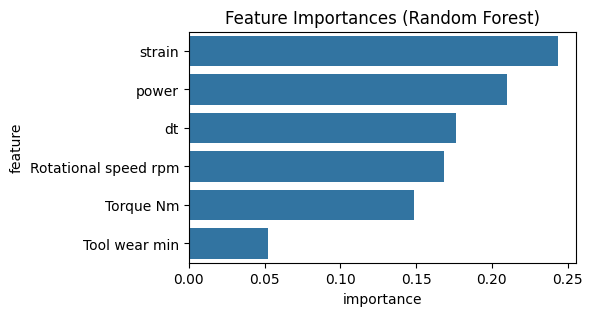

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, max_depth=10, min_samples_leaf = 2)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.93      0.74      0.82        68

    accuracy                           0.99      2000
   macro avg       0.96      0.87      0.91      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.82
training_time: 1.33
inference_time: 0.05


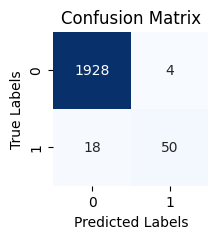

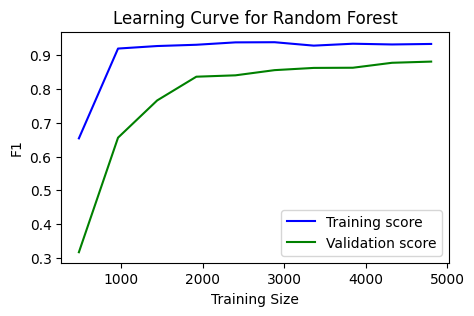

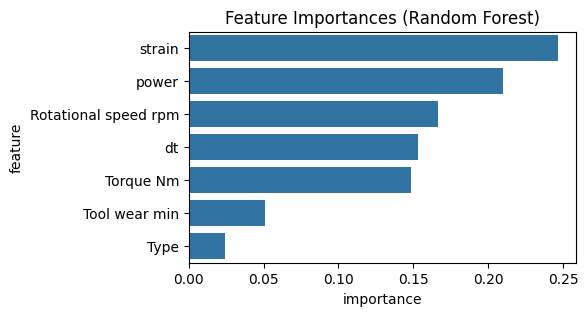

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=True)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, X_val, y_val, max_depth=10, min_samples_leaf = 2)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_val, rf_model.predict(X_val)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_val, rf_model.predict(X_val)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)
plot_feature_importance(rf_model, X_train)

## Tier 2 - Hyperparameter Tuning

Performing Randomized Search...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters found: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': None}
Next 4 Models:

Model 2:
  Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': None}
  Mean Test Score: 0.89

Model 3:
  Parameters: {'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 20, 'class_weight': None}
  Mean Test Score: 0.87

Model 4:
  Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_depth': None, 'class_weight': None}
  Mean Test Score: 0.87

Model 5:
  Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_depth': 20, 'class_weight': None}
  Mean Test Score: 0.87

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
    

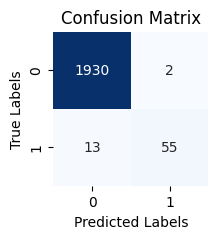

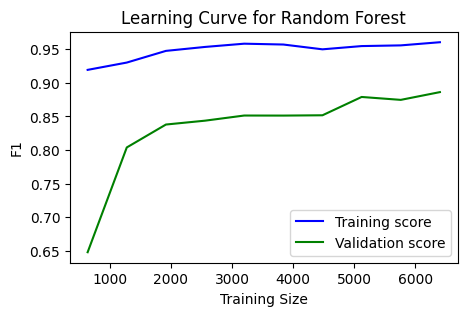


Model 2:
  Precision: 0.95
  Recall: 0.78
  F1-Score: 0.85
  MCC: 0.85


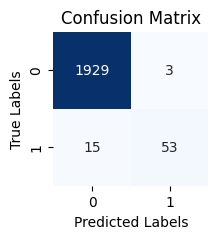

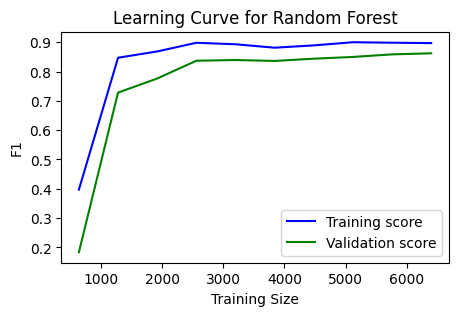


Model 3:
  Precision: 0.95
  Recall: 0.78
  F1-Score: 0.85
  MCC: 0.85


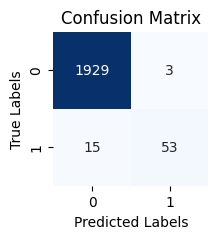

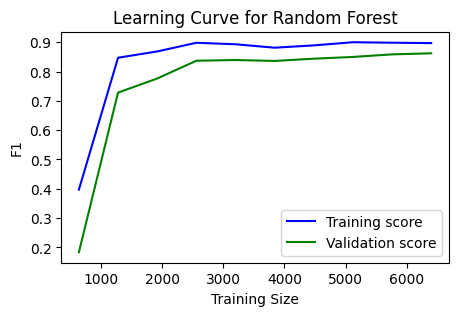


Model 4:
  Precision: 0.95
  Recall: 0.78
  F1-Score: 0.85
  MCC: 0.85


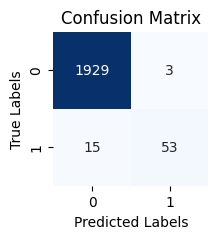

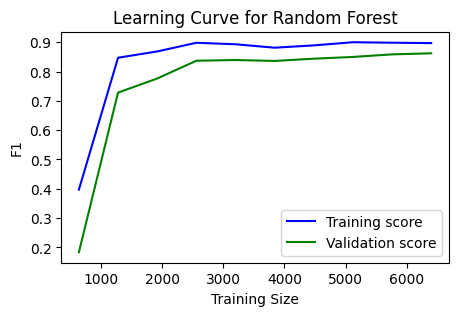


Model 5:
  Precision: 0.95
  Recall: 0.78
  F1-Score: 0.85
  MCC: 0.85


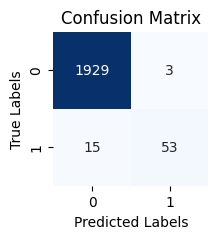

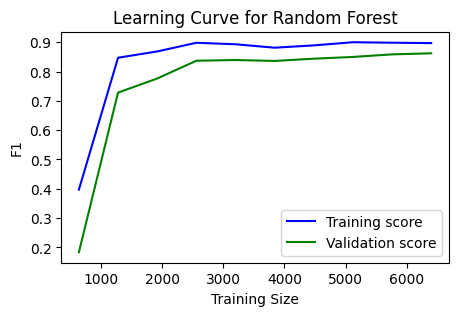

In [ ]:
# Define features and target
#features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
features = ['Type','Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt', 'power', 'strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=None, oversampling=None, manual_tune=False)

# Train and evaluate the Random Forest model without Randomized Search
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test,randomized_search = True )

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_test, rf_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, rf_model.predict(X_test)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)

# Plot learning curves and confusion matrices for the top 3 models
for i, estimator in enumerate(best_estimators):
  if i>0:
    estimator.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = estimator.predict(X_test)

    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print the evaluation metrics
    print(f"\nModel {i+1}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1:.2f}")
    print(f"  MCC: {mcc:.2f}")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot Learning Curve & Confusion Matrix
    plot_confusion_matrix(cm)
    plot_learning_curve(estimator, X_train, y_train, scoring='f1', cv=5)

Training Random Forest without Randomized Search...

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1932
           1       0.96      0.78      0.86        68

    accuracy                           0.99      2000
   macro avg       0.98      0.89      0.93      2000
weighted avg       0.99      0.99      0.99      2000

mcc: 0.86
training_time: 5.39
inference_time: 0.16


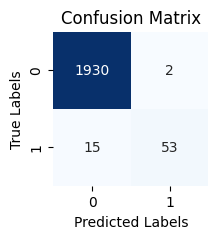

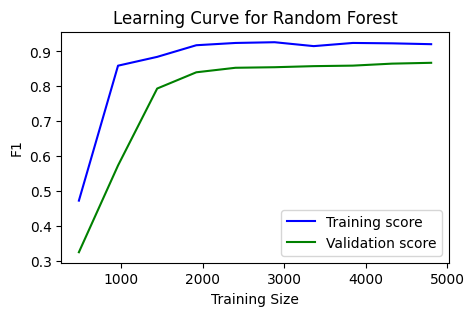

In [ ]:
### Model 2 in previous cell is chosen!

# Define features and target
features = ['Type', 'Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'dt','power','strain']
target = 'Machine failure'

# Preprocess the data
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df, features, target, scalings=scalings, oversampling=None, manual_tune = True)

# Train and evaluate the Random Forest model without Randomized Search
## def train_and_evaluate_rf(X_train, X_test, y_train, y_test, randomized_search=False, random_state=42, cv=5, n_iter=10,
## n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None)
rf_model, metrics, best_estimators = train_and_evaluate_rf(X_train, X_test, y_train, y_test, min_samples_leaf=2, max_depth=None, n_estimators = 300,
                                                           min_samples_split = 10, class_weight = None)

# Print the evaluation metrics
print("\n🔹 Random Forest")
print(classification_report(y_test, rf_model.predict(X_test)))
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")
plot_confusion_matrix(confusion_matrix(y_test, rf_model.predict(X_test)))

# Plot the learning curve & feature importance
plot_learning_curve(rf_model, X_train, y_train)

Best Threshold: 0.6335, Precision: 1.0000, Recall: 0.7353, F1 Score: 0.8475


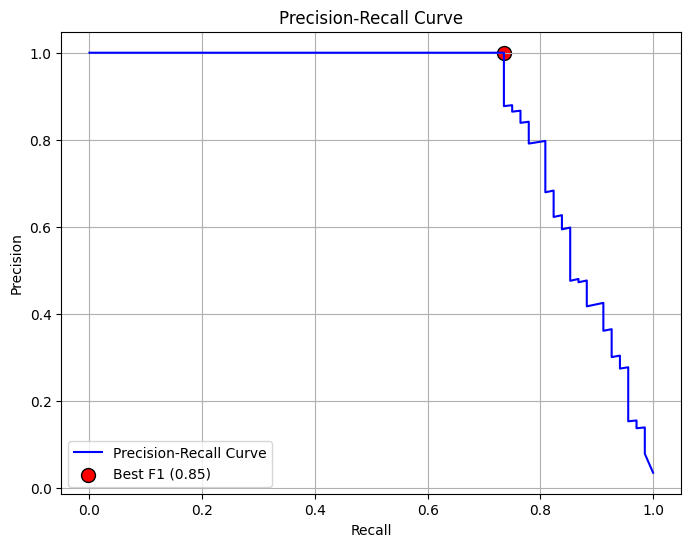

In [ ]:
from sklearn.metrics import precision_recall_curve
#Plotting precision recall curve
# Get predicted probabilities for the positive class
y_scores = rf_model.predict_proba(X_val)[:, 1]  # Probabilities for class 1

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

# Compute F1 scores for each threshold
f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero

# Find the threshold with the best F1 score
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_precision = precisions[best_index]
best_recall = recalls[best_index]
best_f1 = f1_scores[best_index]

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve", color="blue")
plt.scatter(best_recall, best_precision, color="red", s=100, label=f"Best F1 ({best_f1:.2f})", edgecolors='black')

# Labels and legend
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()

# Show the best threshold value
print(f"Best Threshold: {best_threshold:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1 Score: {best_f1:.4f}")

plt.show()

F1 Score: 0.88
Precision: 1.00
Recall: 0.78
MCC: 0.88


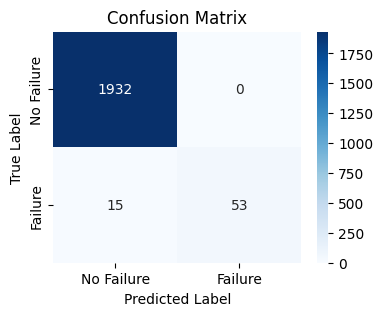

In [ ]:


from sklearn.metrics import precision_recall_curve
#Plotting precision recall curve
# Get predicted probabilities for the positive class
y_scores = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Make predictions using the custom threshold
y_pred_custom = (y_scores >= best_threshold).astype(int)

# Evaluate performance
f1 = f1_score(y_test, y_pred_custom)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
mcc = matthews_corrcoef(y_test, y_pred_custom)
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"MCC: {mcc:.2f}")

#
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)

# Plot the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()